In [3]:
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

from skimage import io, transform
from skimage.transform import radon, iradon

In [97]:
path_empty = "C:/Users/caram/Documents/2024-08-21-Messungen/2024-08-21-Empty/01_100KV_1200MUA.TIFF"
img_empty = img_empty = cv2.imread(path_empty,cv2.IMREAD_UNCHANGED)

In [198]:
image = cv2.imread('C:/Users/caram/Documents/00_Messungen/01/2024-10-16-Ananas-100kV-1200muA-01/000.TIFF', cv2.IMREAD_UNCHANGED)

# Normalize image to 0-1 range and create a binary mask
normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
binary_mask = (normalized_image > np.mean(normalized_image) * 0.9).astype(np.uint8) * 255

# Clean the mask using morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
cleaned_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_OPEN, kernel)

# Detect contours and get bounding box
contours, _ = cv2.findContours(cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea)) if contours else (0, 0, image.shape[1], image.shape[0])

# Create cutout mask
cutout_mask = np.zeros_like(image, dtype=np.uint16)
cutout_mask[y:y+h, x:x+w] = 1

# Prepare new flat field
empty = cutout_mask * img_empty

In [203]:
# Apply flatfield to all imgs & Save into an array

img_empty = img_empty = cv2.imread(path_empty,cv2.IMREAD_UNCHANGED)
folder_path = "C:/Users/caram/Documents/00_Messungen/01/2024-10-16-Ananas-100kV-1200muA-01/"

tiff_files = sorted(glob.glob(os.path.join(folder_path, '*.TIFF')))
if not tiff_files:
    print("Empty or no TIFF")
else:
    first_image = cv2.imread(tiff_files[0],cv2.IMREAD_UNCHANGED)
    
    if first_image is None:
        print(f"Failed to read first file: {tiff_files[0]}")
    else:
        height,width = first_image.shape[:2]
        num_images = len(tiff_files)
        
        Z = np.zeros((height,width,num_images))         # For uncorrected imgs
        Z_corr = np.zeros((height,width,num_images))    # For flatfield corrected imgs

        empty[empty == 0] = np.min(first_image)
    
        for i, file_path in enumerate(tiff_files):
            image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
            
            if image is None:
                print(f"Failed to read {file_path}")
            else:
                Z[:, :, i] = image
                # Z_corr[:, :, i] = np.abs(1-image/img_empty)  # Store flatfield corrected image in the 3D array at index i
                Z_corr[:, :, i] = np.abs(1-image/empty)  # Store flatfield corrected image in the 3D array at index i
        
        # Display final information
        print(f"Stored {num_images} images in the 3D array Z & Z_corr with shape: {Z.shape}")

Stored 100 images in the 3D array Z & Z_corr with shape: (784, 964, 100)


In [206]:
# Let this run if there is a 360 deg rotation. for better reco

folder_path = "C:/Users/caram/Documents/00_Messungen/02/2024-10-16-Ananas-100kV-1200muA-02/"

tiff_files = sorted(glob.glob(os.path.join(folder_path, '*.TIFF')))

new_imgs = []
new_imgs_corr = []

for i, file_path in enumerate(tiff_files):
    image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
    image_corr = np.abs(1-image/empty)
    
    if image is None:
        print(f"Failed to read {file_path}")
    else:
        image = np.expand_dims(image, axis=2)
        image_corr = np.expand_dims(image_corr, axis=2)

        new_imgs.append(image)
        new_imgs_corr.append(image_corr)

new_imgs_arr = np.concatenate(new_imgs, axis = 2)
Z = np.concatenate((Z, new_imgs_arr), axis=2)

new_imgs_corr_arr = np.concatenate(new_imgs_corr, axis = 2)
Z_corr = np.concatenate((Z_corr, new_imgs_corr_arr), axis=2)

# Display final information
print(f"Stored {len(tiff_files)} images in the 3D array Z & Z_corr with shape: {Z.shape}")

Stored 100 images in the 3D array Z & Z_corr with shape: (784, 964, 200)


In [205]:
Z_corr.shape

(784, 964, 100)

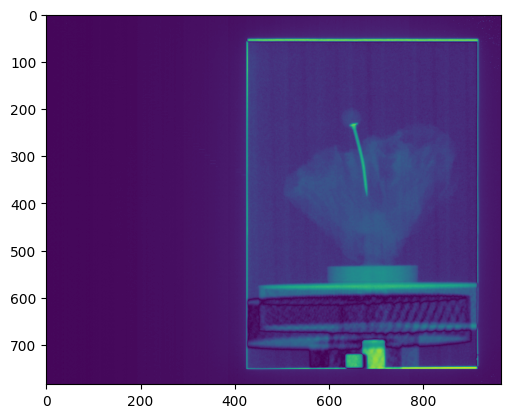

In [208]:
plt.imshow(Z_corr[:,:,150])

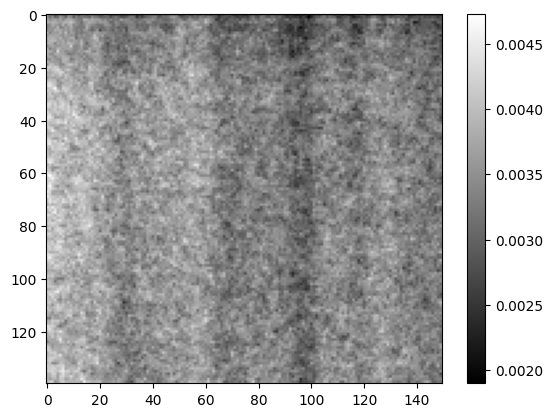

In [125]:
plt.imshow(Z_corr[60:200,450:600,0], cmap="grey")
plt.colorbar()

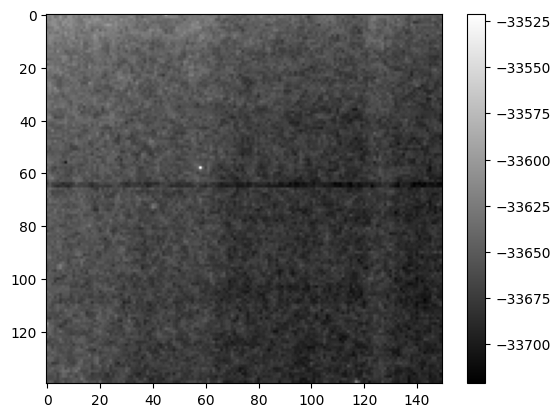

In [124]:
plt.imshow(1-Z[60:200,450:600,0], cmap="grey")
plt.colorbar()

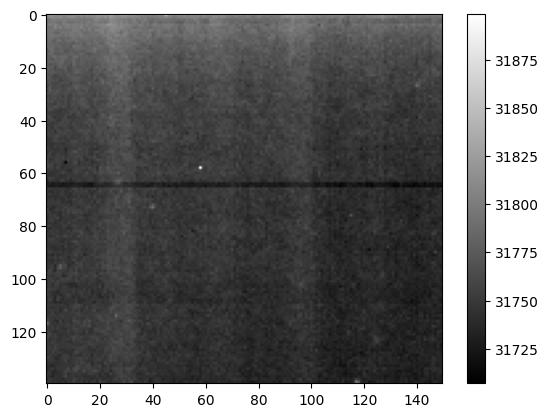

In [127]:
plt.imshow(1-empty[60:200,450:600], cmap="grey")
plt.colorbar()

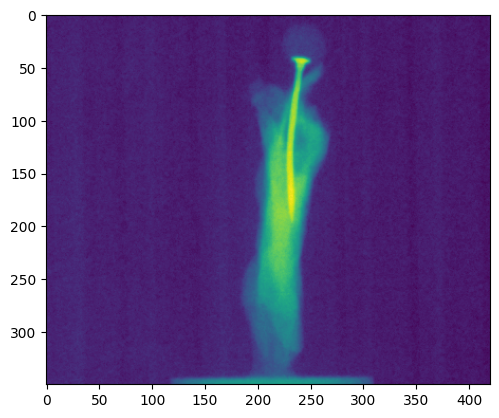

In [165]:
plt.imshow(Z_corr[190:540,480:900,90])      #190:540 480:900

In [209]:
Z_prime = Z[190:540,480:900,:]
Z_corr_prime = Z_corr[190:540,480:900,:]

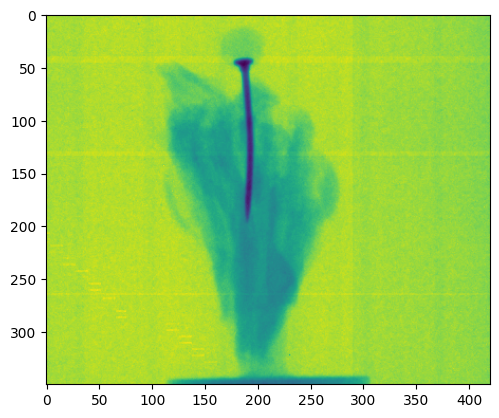

In [211]:
plt.imshow(Z_prime[:,:,0])

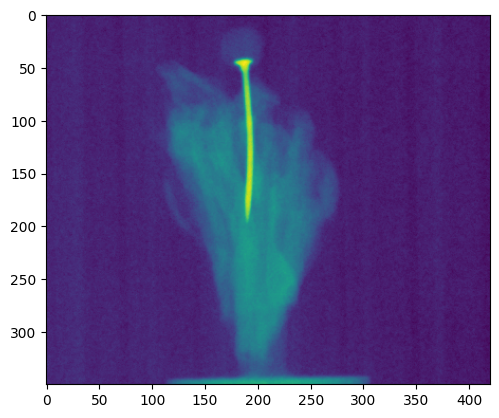

In [212]:
plt.imshow(Z_corr_prime[:,:,0])

In [240]:
# Apply all corrections and get Z_final

# threshold_value = 0.1 * np.max(Z_corr_prime)
threshold_value = 2.8 * np.min(Z_corr_prime)

thresholded = np.where(Z_corr_prime > threshold_value, 1.0, 0.0)
thresholded_uint8 = (thresholded * 255).astype(np.uint8)

fullmask = np.zeros_like(Z_corr_prime, dtype=np.float32)
Z_final = np.zeros_like(Z_corr_prime)

# Get a binary 3d mask
for i in range(Z_corr_prime.shape[2]):
    contours, _ = cv2.findContours(thresholded_uint8[:,:,i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(Z_corr_prime[:,:,i], dtype=np.float32)
    cv2.drawContours(mask, contours, -1, (1.0), thickness=cv2.FILLED)
    fullmask[:,:,i] = mask
    # Z_final[:,:,i] = Z_corr_prime[:,:,i] * mask

Z_final = Z_corr_prime * fullmask

In [216]:
np.min(Z_corr_prime)

0.001392592592592612

In [219]:
0.1 * np.max(Z_corr_prime)

0.0021119261713204

In [242]:
2.8 * np.min(Z_corr_prime)

0.003899259259259313

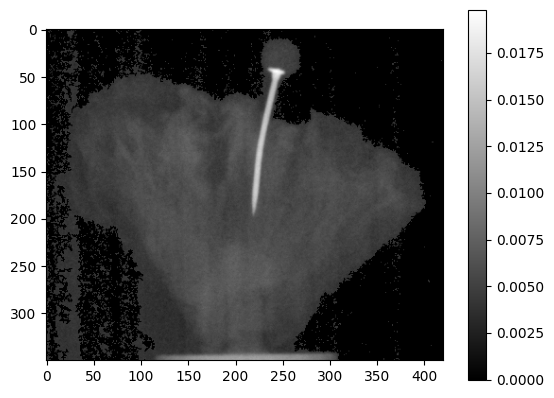

In [241]:
plt.imshow(Z_final[:,:,50], cmap="grey")
plt.colorbar()

In [261]:
theta = np.linspace(0.,360.,Z_final.shape[2], endpoint=False)

FB_final = np.zeros((Z_final.shape[1],Z_final.shape[1],Z_final.shape[0]))
for i in range(Z_final.shape[0]):
    S = np.squeeze(Z_final[i,:,:])
    FB_final[:,:,i] = iradon(S, theta=theta)

In [262]:
save_folder = "C:/Users/caram/Documents/00_Messungen/03/saved_arrays/"

# Ensure the folder exists, create it if it doesn't
os.makedirs(save_folder, exist_ok=True)

# Define the full path including the filename (without .npy extension)
save_path = os.path.join(save_folder, "FB_final")

# Save the array to the specified folder
np.save(save_path, FB_final)

print(f"Array saved to {save_path}.npy")

Array saved to C:/Users/caram/Documents/00_Messungen/03/saved_arrays/FB_final.npy


In [259]:
FB_final.shape

(420, 420, 350)

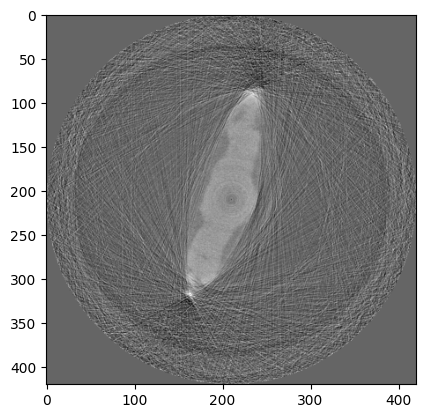

In [277]:
plt.imshow(FB_final[:,:,250], cmap="grey")

In [278]:
import napari
viewer = napari.Viewer()
viewer.dims.ndisplay = 3
viewer.add_image(FB_final)

<Image layer 'FB_final' at 0x29967a896d0>